In [92]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [93]:
import os
import sys
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

sys.path.append(os.path.abspath(''))

In [94]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2022-09-29 19:25:01--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: 'plot_image_grid.py.1'

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-09-29 19:25:01 (24.3 MB/s) - 'plot_image_grid.py.1' saved [1608/1608]



In [95]:
## 디바이스 세팅
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [96]:
DATA_DIR = './'
obj_filename = os.path.join(DATA_DIR, 'cow_mesh/cow.obj')
mesh = load_objs_as_meshes([ obj_filename ], device = device)

In [97]:
verts = mesh.verts_packed()
print(verts)
N = verts.shape[0] # row
center = verts.mean(0) # 평균값
scale = max((verts - center).abs().max(0)[0]) # 모든 정점값에 절대값과의 오차에 절대값으로 생성 후 0번 인덱스의 values의 값을 가져옴

mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

tensor([[ 0.3488, -0.3350, -0.0832],
        [ 0.3131, -0.3991,  0.8812],
        [ 0.2668,  0.1816,  0.1227],
        ...,
        [-0.0132, -0.0889,  1.0422],
        [-0.0137, -0.0943,  1.0340],
        [-0.0137, -0.0796,  1.0469]])


In [98]:
# mesh를 랜더링을 원하는 다른 관점의 수
num_views = 20

elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

lights = PointLights(device = device, location = [ [0.0, 0.0, -3.0] ])

R, T = look_at_view_transform(
    dist = 3.0,  # 물체와 카메라 사이의 거리
    elev = elev, # 물체와 카메라 사이의 라디안 각도
    azim = azim  # 물체와 카메라 사이의 벡터를 정사영한 직선과 Y평면 사이의 각도
)

cameras = FoVPerspectiveCameras(
    device = device,
    R = R,
    T = T
)

camera = FoVPerspectiveCameras( #
    device = device,
    R = R[None, 1, ...],  # 회전 행렬(N, 3, 3)
    T = T[None, 1, ...]   # 형상의 번역 행렬(N, 3)
)

raster_settings = RasterizationSettings( # 물체의 표현을 위해 픽셀을 결정하는 작업
    image_size = 256,    # 이미지 사이즈
    blur_radius = 0.0,   # 면적을 확장하는데 사용되는 0 ~ 2 플로트 범위
    faces_per_pixel = 1, # 픽셀 당 추적하는 면적의 수
)

renderer = MeshRenderer(
    rasterizer = MeshRasterizer(
        cameras = cameras,
        raster_settings = raster_settings
    ),
    shader = SoftPhongShader( # 퐁 쉐이더: 하이라이트나 반사광을 표현하기 위해 설정한다
        device = device,
        cameras = cameras,
        lights = lights
    )
)

meshes = mesh.extend(num_views) # mesh 배열의 뒤에 붙임
target_images = renderer(
    meshes,
    camerasa = cameras,
    lights = lights
)

target_rgb = [ target_images[ i, ..., :3 ] for i in range(num_views) ]
target_cameras = [ FoVPerspectiveCameras(
    device = device,
    R = R[None, i, ...],
    T = T[None, i, ...]
    )
    for i in range(num_views)
]



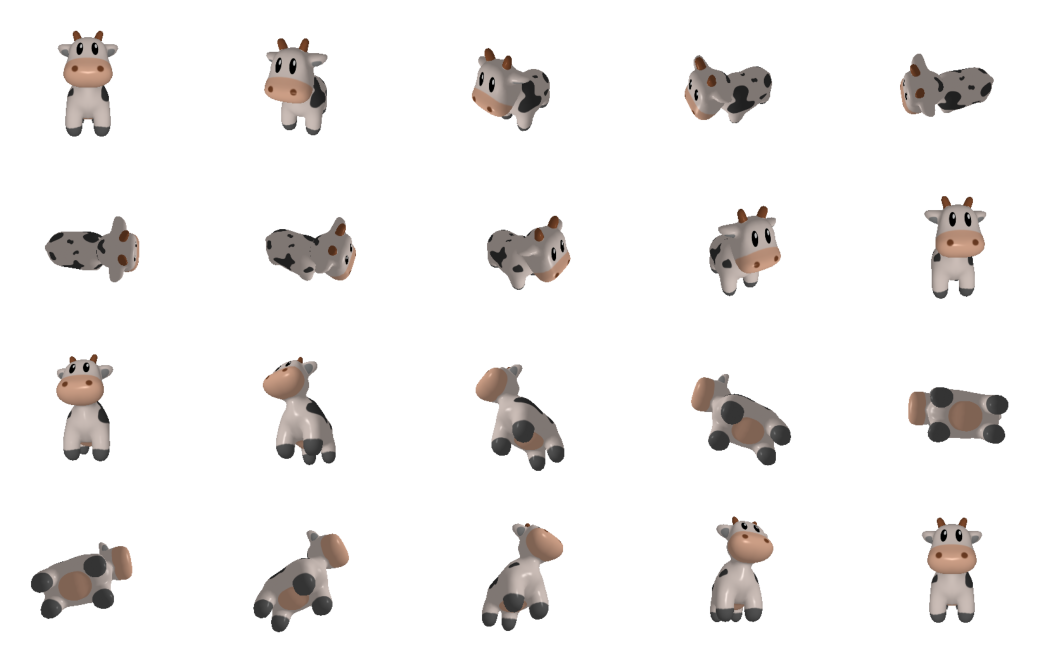

In [99]:
image_grid(target_images.cpu().numpy(), rows = 4, cols = 5, rgb = True)
plt.show()

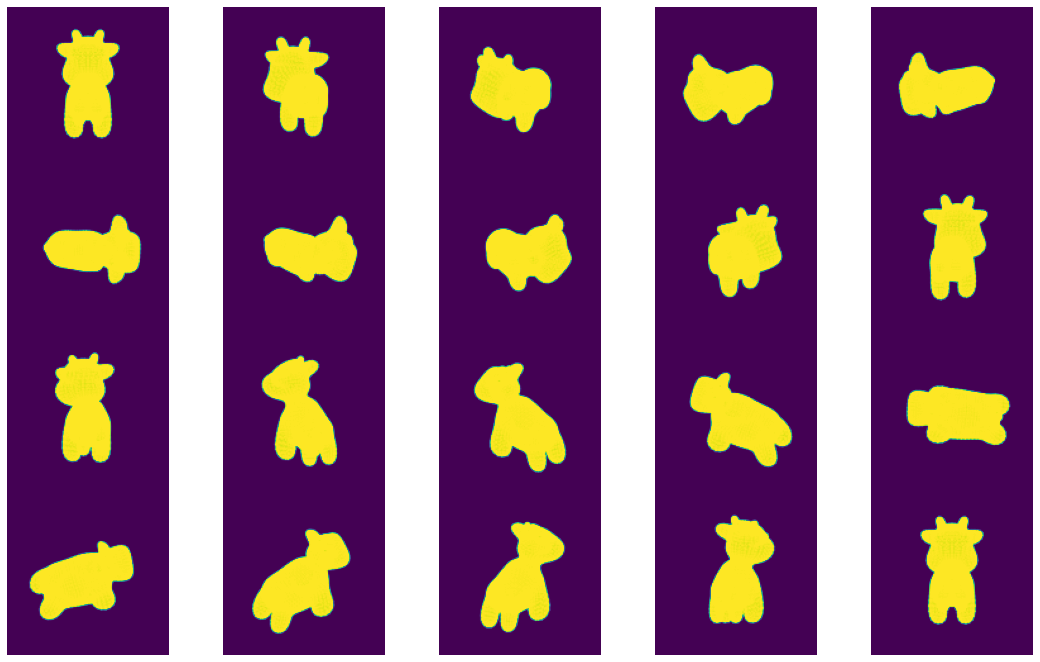

In [100]:
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size = 128,
    blur_radius = np.log(1.0 / 1e-4 - 1.0) * sigma,
    faces_per_pixel = 100
)

# 실루엣 렌더러
renderer_silhouette = MeshRenderer(
    rasterizer = MeshRasterizer(
        cameras = cameras,
        raster_settings = raster_settings_silhouette
    ),
    shader = SoftPhongShader()
)

silhouette_images = renderer_silhouette(
    meshes,
    cameras = cameras,
    lights = lights
)
target_silhouette = [ silhouette_images[ i, ..., 3 ] for i in range(num_views) ]

image_grid(silhouette_images.cpu().numpy(), rows = 4, cols = 5, rgb = False)
plt.show()

In [101]:
def visualize_prediction(predicted_mesh, renderer = renderer_silhouette, target_image = target_rgb[1], title="", silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

def plot_losses(losses):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label = k + "  loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [102]:
src_mesh = ico_sphere(4, device)

In [103]:
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size = 128,
    blur_radius = np.log(1.0 / 1e-4 - 1.0) * sigma,
    faces_per_pixel = 50,
)

renderer_silhouette = MeshRenderer(
    rasterizer = MeshRasterizer(
        cameras = camera,
        raster_settings = raster_settings_soft
    ),
    shader = SoftSilhouetteShader()
)

In [104]:
num_views_per_iteration = 2

Niter = 2000

plot_period = 250

%matplotlib inline

losses = {
    "silhouette": {
        "weight": 1.0,
        "values": []
    },
    "edge": {
        "weight": 1.0,
        "values": []
    },
    "normal": {
        "weight": 0.01,
        "values": []
    },
    "laplacian": {
        "weight": 1.0,
        "values": []
    }
}


def update_mesh_shape_prior_losses(mesh, loss):
    loss["edge"] = mesh_edge_loss(mesh)
    loss["normal"] = mesh_normal_consistency(mesh)
    loss["laplacian"] = mesh_laplacian_smoothing(mesh)

verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device = device, requires_grad = True)

optimizer = torch.optim.SGD([ deform_verts ], lr = 1.0, momentum = 0.9)

In [105]:
loop = tqdm(range(Niter))

for i in loop:
    optimizer.zero_grad()
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    loss = { k: torch.tensor(0.0, device=device) for k in losses }
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))


    loop.set_description("total_loss = %.6f" % sum_loss)

    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
                             target_image=target_silhouette[1])

    sum_loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

ValueError: Wrong number (20) of cameras for 1 meshes